In [87]:
import pandas as pd
from matplotlib import pyplot as plt
import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
import torch.nn as nn
import seaborn as sns
from collections import defaultdict
import re


## 1. Load into Data frane

In [54]:
df = pd.read_csv('data/imdb.csv')

In [55]:
print(df.groupby('sentiment').count())
print(df.head())

           review
sentiment        
negative    25000
positive    25000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### Remove Unwanted characters, and try to use only the first 15000 rows of the data to speed up our fine-tunning.
- remove punctuation marks
- remove characters which are not letters or digits
- remove successive whitespaces
- convert the text to lower case
- strip whitespaces from the beginning and the end of the reviews

In [56]:
df = df.head(15000)
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))

In [57]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


### Plot the data distribution over the labels

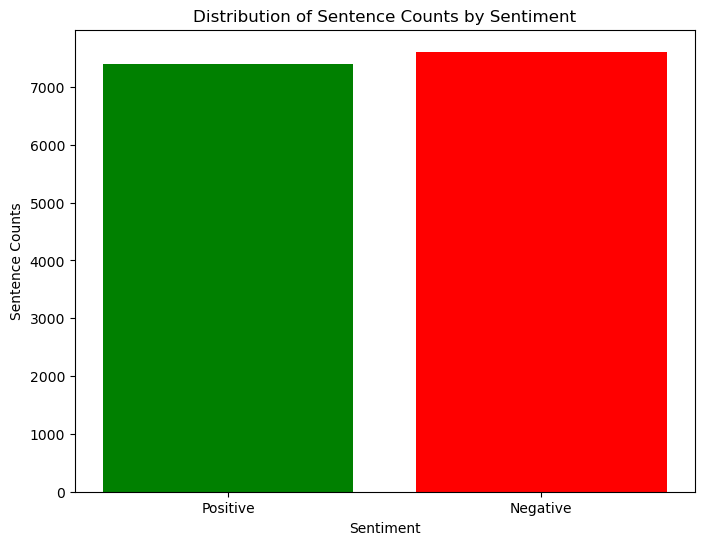

In [58]:
# Calculate the number of sentences for each sentiment category
positive_counts = len(df[df.sentiment == 1])
negative_counts = len(df[df.sentiment == 0])

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_counts, negative_counts], color=['green', 'red'])
plt.title('Distribution of Sentence Counts by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Sentence Counts')
plt.show()

## 2. Preprocess our data, padding them (masking them appropriately)
Let’s first see how the BERT tokenizer converts sentences into token ids.
token ids : it is an integer that represents a particular token.

attention mask : it is a sequence of ones and zeroes to tell the model which token comes from input sentence (segment id =1) and which are just padding token(segment id =0).

padding : when we train BERT model we make sure that every input to the model should have same size that means same length of inputs so that the model can perform back propagation efficiently but all our input which are review text can not be in same size, some can be small review and some can be large. Padding is the technique where we make our entire review in the same size but first we have to decide a fixed length or max_length.

The function tokenizer.tokenize() and tokenizer.convert_tokens_to_ids() are general purpose functions and it does not convert our review compatible for training data like adding [CLS] token at beginning, padding and [SEP] token at the end.

In [59]:
train, test = train_test_split(df, test_size=0.2)

train_sentences = train.review.values
train_labels = train.sentiment.values
test_sentences = test.review.values
test_labels = test.sentiment.values

print(train_sentences.shape, test_sentences.shape)

(12000,) (3000,)


In [60]:
BERTMODEL = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(BERTMODEL,
                                          do_lower_case=True)

Hugging face library provides another function called tokenizer.encode_plus() which we will use to perform almost entire preprocessing steps in one go. It

- converts reviews into tokens
- adds [CLS] token at the beginning of input
- performs padding if sequence length is less than max_len
- performs truncation if sequence length is greater than max_len
- adds [SEP] token at the end of sequence.

In [ ]:
def generate_data(data,labels):
  input_ids = []
  attention_masks = []

  for sent in data:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In the end, each sentece;

- Tokenized
- [CLS] Token added at the beginning
- [SEP] Token added at the end
- Padded or truncated to a fixed length of tokens, I choosed 64 for this example
- Attention masks generated

In [62]:

train_input_ids, train_attention_masks,train_labels = generate_data(train_sentences,train_labels)
test_input_ids, test_attention_masks,test_labels = generate_data(test_sentences,test_labels)

print('Original: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])

/var/folders/zq/m7j0g5vs1b32pfht2xtpnw4m0000gn/T/ipykernel_55678/4219197917.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Original:  my husband and i enjoy the doodlebops as much as our 8 month old baby does we have bought him dvd s and cd s just so we can watch and listen to them ourselves they are fun energetic and very entertaining they encourage children to be active share and care they always have a positive message along with fun entertainment every time our son hears the theme song he quickly turns his head toward the television and starts bouncing up and down in excitement dee dee is a wonderful singer she has a great voice moe is a great dancer i would recommend the doodlebops to anyone with children our favorite song is the bird song you just can not help but smile and want to dance when you hear it
Token IDs: tensor([  101,  2026,  3129,  1998,  1045,  5959,  1996, 20160, 10362,  5092,
         4523,  2004,  2172,  2004,  2256,  1022,  3204,  2214,  3336,  2515,
         2057,  2031,  4149,  2032,  4966,  1055,  1998,  3729,  1055,  2074,
         2061,  2057,  2064,  3422,  1998,  4952,  2000,

### Create a Dataloaders

In [88]:
batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Load the BertForSequenceClassification
 This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

##### Bert Model Output Overview

- last_hidden_state : It is the first output we get from the model and as its name it is the output from last layer. The size of this output will be (no. of batches , no. of tokens in each batch, size of hidden layer). in our case we have only 16 batch with 50 token and for BERT-base size of the hidden layer is 768 so the size of last hidden state (16,50,768) can be seen in the code above.

- Pooler Output : Creator of BERT model said that pooler_output which corresponds to the last hidden state of [CLS] token does not have any interpretability but it is best choice as an input for a classifier that can be fine tuned on a separate dataset. The main reason behind this is the way it pretrained. We must not forget that we are using the BERT model as transfer learning which is already pre trained on large amounts of data. [CLS] token is always used as a starting token while performing pretraing using a masked language model and next sentence prediction that’s why a pooler output which itself doesn’t have any interpretability but it captures all the information for a particular input.

- Hidden_state : One good reason to love this model is its hidden state. BERT application is not limited to using pooler output to fine tune the classifier but one can also explore the advantages by using its hidden states.

In [91]:
model = BertForSequenceClassification.from_pretrained(
                                                      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                        num_labels = 2, # The number of output labels--2 for binary classification.
                                                                        # You can increase this for multi-class tasks.   
                                                        output_attentions = False, # Whether the model returns attentions weights.
                                                        output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8)
                  
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)  

/Users/tango.tew/miniconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Create functions for calculating training time and accuracy.

In [93]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Now that the model and data are ready, we can start the training.

- Unpack our data inputs and labels
- We need to feed model with input_id, attentions mask and labels.
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()

In [94]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]


        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        

    t0 = time.time()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,   
            'Training Time': training_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    375.    Elapsed: 0:09:03.
  Batch    80  of    375.    Elapsed: 0:19:31.
  Batch   120  of    375.    Elapsed: 0:30:11.
  Batch   160  of    375.    Elapsed: 0:40:02.


KeyboardInterrupt: 

## Evaluation
Our Bert model trained for 4 epochs, let’s test it.

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass, feeding input data through the network
- Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# Prediction on test set

model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

print('Preds are ready')

In [ ]:
from sklearn.metrics import f1_score
f1_score = f1_score(test_labels, prediction_scores, average='macro')
print(f1_score)

### Improvements
- Most of the sentences are longer than 64 words, setting max lenght to higher number will require more calculation.
- Increasing epoch number
- Using more data

# Learning and testing 

### Determine the appropriate max length
The best way to decide max_len for our task is plotting a distribution graph for the number of words in each review. We will assign max_len to that value for which most of the review is covered without truncation.

In [25]:
lengths = np.array([len(x.split()) for x in df['review']])
print(lengths.max())

2470


/Users/tango.tew/miniconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-3.9305555555555554, 0.5, 'Sentence Length')

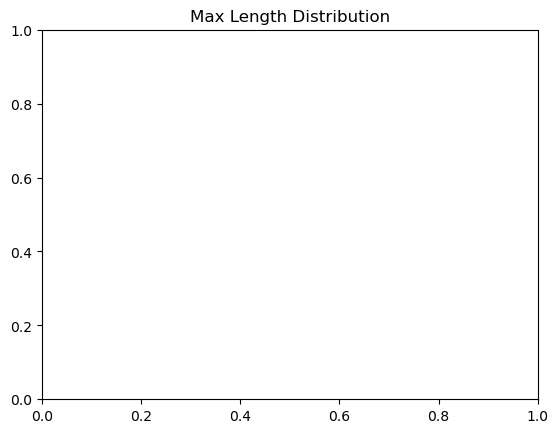

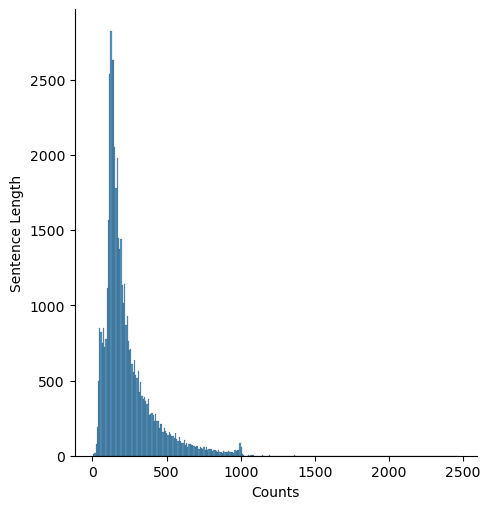

In [26]:
plt.figure()
plt.title('Max Length Distribution')
sns.displot(lengths)
plt.xlabel('Counts')
plt.ylabel('Sentence Length')


#### Define Training Function
The function below trains the model (forward pass and backward pass) for one epoch and also calculate accuracy and average loss for an epoch.

In [39]:
def train_model(model, data_loader, criterion, optimizer, scheduler, BATCH_SIZE, MAX_LEN, n_examples):
    model.train()
    train_loss = []
    correct_predictions = 0

    for s in data_loader:
        input_ids = s['input_ids']
        attention_mask = s['attention_mask']
        targets = s['target']

        #forward props
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, targets)
        _, pred_classes = torch.max(predictions, dim=1)

        #back propagate
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # training loss and number of predictions(accuracy)
        train_loss.append(loss.item())
        correct_predictions += torch.sum(pred_classes == targets)

        return correct_predictions.double() / n_examples, np.mean(train_loss)

#### Validation function
This fuction evaluate model performance on evaluation data for every epoch by calculation accuracy and average loss.

In [40]:
def eval_model(model, data_loader, criterion, BATCH_SIZE, MAX_LEN, n_examples):
    model.eval()
    val_loss = []
    correct_predictions = 0

    with torch.no_grad():
        for s in data_loader:
            input_ids = s['input_ids']
            attention_mask = s['attention_mask']
            targets = s['target']

            #forward props
            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, targets)
            _, pred_classes = torch.max(predictions, dim=1)

            # validation loss and number of predictions(accuracy)
            val_loss.append(loss.item())
            correct_predictions += torch.sum(pred_classes == targets)

    return correct_predictions.double() / n_examples, np.mean(val_loss)

### 7. Train and Evaluate Model
In this loop we are calling functions train_model() and eval_model() and printing the accuracy and loss for both training and validation data for every epoch and also saving the model if model performance on validation data improves than the performance in previous epoch.

In [41]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 20

for epoch in range(EPOCHS):
    # Training
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    model = SentimentClassifier(num_classes)
    train_acc, train_loss = train_model(model, train_loader, criterion, optimizer, scheduler, BATCH_SIZE, max_length, len(training_dataset))

    #validation
    val_acc, val_loss = eval_model(model, val_loader, criterion, BATCH_SIZE, max_length, len(val_dataset))

    # Saving the training logs
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f'Training Loss: {train_loss}, Training Accuracy: {train_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

    # Saving the best model
    if val_acc > best_accuracy:
        best_model = f'best_model_state{val_acc}.bin'
        torch.save(model.state_dict(), best_model)
        best_accuracy = val_acc

Epoch 1/5


KeyboardInterrupt: 

The way I printed epochs ,loss and accuracy might feel like you are training this model in Keras framework.

Training this model in my local system took a lot of time as I didn’t have any GPU installed. I used my mac m2 only for training purpose which you can

### 8. Load and do some Inferences

In [1]:
# Load the pre-trained BERT model and tokenizer

# Load the trained model weights from the `best_model.bin` file
classifier_model.load_state_dict(torch.load('./best_model_state0.6049382716049383.bin', map_location=torch.device('cpu')))  # Load model weights

# Set the model to evaluation mode
classifier_model.eval()

sentence = 'I do not like this movie'

# Tokenize the sentence
tokens = tokenizer.tokenize(sentence)
encoding = tokenizer.encode_plus(
    tokens,
    max_length=50,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)



NameError: name 'classifier_model' is not defined

In [29]:
# Perform inference
with torch.no_grad():
    outputs = classifier_model(encoding['input_ids'], encoding['attention_mask'])
    # logits = outputs.logits
    predicted_labels = torch.argmax(outputs, dim=1)

# Convert predicted labels to human-readable sentiment labels
sentiment_labels = ['Negative', 'Positive']
predicted_sentiment = sentiment_labels[predicted_labels.item()]

print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: Positive
